In [1]:
import pandas as pd
import numpy as np 

#Statistics Module 
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import anderson, shapiro
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from scipy import stats
import pylab
from collections import Counter

#visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## I. Import Dataset: Load the dataset.

In [2]:
df = pd.read_csv('victoria.csv')
df.area = df.area.str.replace(',','.').astype('float64')
df.conservation = df.conservation.str.replace('1A','A')
df.conservation = df.conservation.str.replace('2A','B')
df.conservation = df.conservation.str.replace('2B','C')
df.conservation = df.conservation.str.replace('3A','C')
df.totalprice = df.totalprice.str.replace(',','.').astype('float64')
df.head()

,row.labels,totalprice,area,zone,category,age,floor,rooms,out,conservation,toilets,garage,elevator,streetcategory,heating,tras
0,1,228000.0,7.531000e+09,Z45,4B,33,3,5,E100,C,1,0,1,S3,3A,0
1,2,409000.0,1.006500e+09,Z31,3B,5,7,5,E50,A,2,1,1,S5,4A,1
2,3,200000.0,8.887000e+09,Z52,3A,14,8,5,E50,A,2,0,1,S2,3A,0
3,4,180000.0,6.261000e+09,Z62,4A,41,3,4,E50,B,1,0,0,S3,1A,0
4,5,443600.0,1.461500e+09,Z31,3A,22,6,7,E100,A,2,0,1,S4,4A,1


In [3]:
df.isnull().sum()

row.labels        0
totalprice        0
area              0
zone              0
category          0
age               0
floor             0
rooms             0
out               0
conservation      0
toilets           0
garage            0
elevator          0
streetcategory    0
heating           0
tras              0
dtype: int64

## II. Exploratory Data Analysis: Create summary of the dataset, with python function. (mean, median, modus, max, min, range)


In [4]:
df.describe()

,row.labels,totalprice,area,age,floor,rooms,toilets,garage,elevator,tras
count,218.000000,218.000000,2.180000e+02,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,109.500000,280741.523853,5.718657e+09,19.899083,4.440367,4.853211,1.467890,0.243119,0.798165,0.807339
std,63.075352,69298.459358,3.455007e+09,14.595590,2.126988,0.634285,0.500116,0.450881,0.402293,0.406787
min,1.000000,155000.000000,5.300000e+01,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000
25%,55.250000,228500.000000,1.187250e+09,11.000000,3.000000,5.000000,1.000000,0.000000,1.000000,1.000000
50%,109.500000,269750.000000,7.118500e+09,16.000000,4.000000,5.000000,1.000000,0.000000,1.000000,1.000000
75%,163.750000,328625.000000,8.542750e+09,24.000000,5.000000,5.000000,2.000000,0.000000,1.000000,1.000000
max,218.000000,560000.000000,9.992000e+09,118.000000,12.000000,7.000000,2.000000,2.000000,1.000000,2.000000


## III. Data Visualization: Create any kind suitable plot of dataset, it will provide a lot of insight into the problem.


### Seperate data type, numerical and categorical

In [5]:
def list_dtypes(df):
    categorical_list = []
    numerical_list = []
    for col in df.columns.tolist():
        if df[col].dtype=='object':
            categorical_list.append(col)
        else:
            numerical_list.append(col)
    print('Number of categorical features:', str(len(categorical_list)))
    print('Number of numerical features:', str(len(numerical_list)))

    return categorical_list, numerical_list

In [6]:
categorical_list, numerical_list = list_dtypes(df)

Number of categorical features: 6
Number of numerical features: 10


In [7]:
def strong_corr(df, ycol=None):
    '''
    Documentation :
    --------------
    * Df   : Dataset name
    * ycol : The target column of the dataframe
    '''
    df_num_corr = df.corr()[ycol][:-1] # -1 because the latest row is SalePrice
    strong_corr = df_num_corr[abs(df_num_corr) > 0.6].sort_values(ascending=False)
    corr = pd.Series(strong_corr, name='Strong Correlation')
    table = pd.concat([corr], axis = 1) 
    print ('Columns have strong correlation :')
    print(table)
    list_features = table.index.values 
    
    return list_features

In [8]:
#Strong Correlation 
# 1. define df
dataframe = df

# 2. define target of df
ycol = 'totalprice'

# 3. Strong Correlation 
list_features = strong_corr(dataframe,ycol)

Columns have strong correlation :
            Strong Correlation
totalprice            1.000000
toilets               0.687571


In [9]:
#Univariat Analisys
def Univariate_plot(df, column, vartype, hue = None ):
    '''
    Documentation :
    Univariate function will plot the graphs based on the parameters.
    * df      : dataframe name
    * column  : Column name
    * vartype : variable type : continuos or categorical
                (0) Continuos/Numerical   : Distribution, Violin & Boxplot will be plotted.
                (1) Categorical           : Countplot will be plotted.
    * hue     : It's only applicable for categorical analysis.
    '''
    sns.set(style="darkgrid")
      
    if vartype == 0:
        fig, ax=plt.subplots(nrows = 3, ncols=1,figsize=(12,12))
        # Distribution Plot
        ax[0].set_title("Distribution Plot",fontsize = 10)
        sns.distplot(df[column], kde=False, fit=stats.gamma, color='darkblue', label = column, ax=ax[0])
        
        # Violinplot 
        ax[1].set_title("Violin Plot",fontsize = 10)
        sns.violinplot(data= df, x=column, color = 'limegreen', inner="quartile", orient='h', ax=ax[1])
        
        #Boxplot
        ax[2].set_title("Box Plot",fontsize = 10)
        sns.boxplot(data =df, x=col,color='cyan',orient="h",ax=ax[2])
        
        fig.tight_layout()
        
    if vartype == 1 :
        #Count plot 
        fig = plt.figure(figsize=(12,6))
        plt.title('Count Plot',fontsize = 20)
        ax=sns.countplot(data=df, x=column, palette="Blues_r")
        ax.set_xlabel(column, fontsize = 15)
        ax.tick_params(labelsize=12)

### Plot for numerical feature

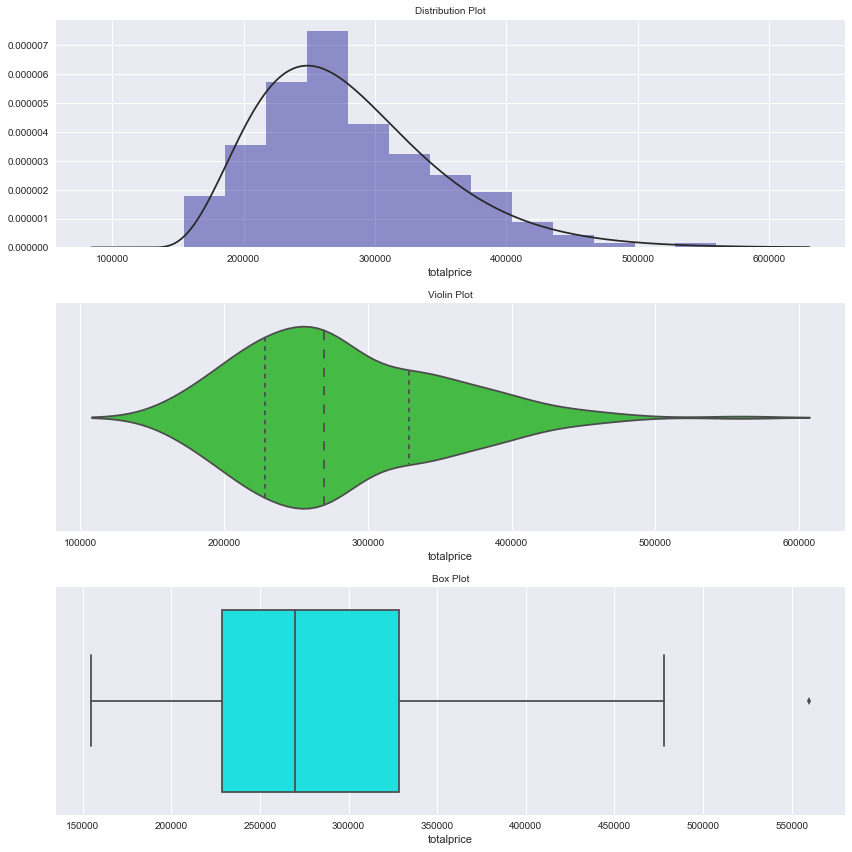

In [10]:
# 1. Define Dataframe
dataframe = df

# 2. Define feature
col = 'totalprice'

# 3. Vartype 
var_type = 0   
 
#Visualization
Univariate_plot(df=dataframe,column = col, vartype = var_type )

### Plot for categorical feature

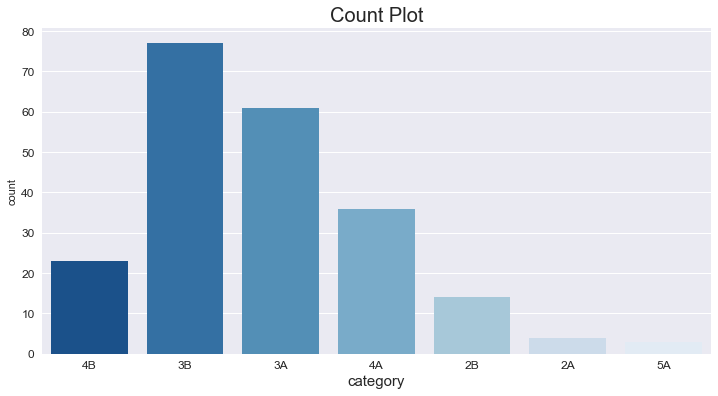

In [11]:
# 1. Define Dataframe
dataframe =df

# 2. Define feature
col = 'category'

# 3. Vartype 
var_type = 1   
 
#Visualization
Univariate_plot(df=dataframe,column = col, vartype = var_type )

### Plot bivariate, toilets and totalprice

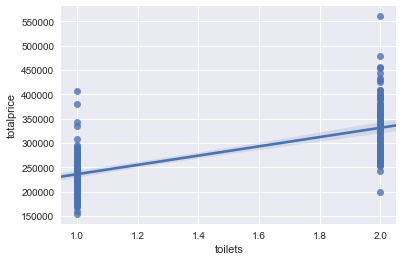

In [12]:
sns.regplot(x='toilets', y='totalprice', data=df)

In [13]:
def multivariate(df, column):
    corrMatt = df[column].corr()
    mask = np.array(corrMatt)
    mask[np.tril_indices_from(mask)] = False
    fig,ax= plt.subplots(figsize=(15,12))
    fig.set_size_inches(20,5)
    sns.heatmap(corrMatt, mask=mask,vmax=0.9, square=True,annot=True)

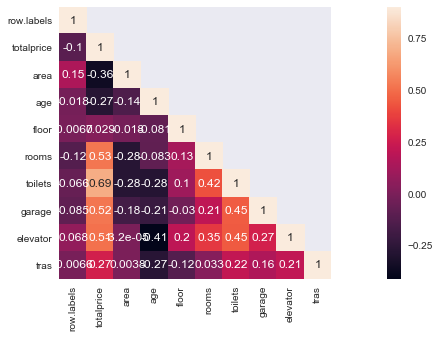

In [14]:
# 1. Define Dataframe
dataframe = df

# 2. Define Column
colname = numerical_list

# 3. Visualization 
multivariate(dataframe, colname)

### IV. Variable Selection: Choose the variable and its reason.


variable that has been choose are elevator, garage, rooms, and toilets. because of the correlation are relative high than other's.

In [15]:
X = df[['garage', 'elevator', 'rooms', 'toilets']]
y = df.totalprice

### V. Modelling: Create models using Regression


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(152, 4) (152,)
(66, 4) (66,)


In [17]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

### VI. Accuracy or Error: Calculate the Error using the helper function from the library, from dataset only


In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

RMSE = sqrt(mean_squared_error(y_test, y_pred))
print('Nilai RMSE : %.2f' % (RMSE))

Nilai RMSE : 41878.65
